# 네이버 영화리뷰 감성분석 도전

영문 텍스트의 감정 분석이 아닌 한국어 텍스트로 감성분석해보자.

[네이버 영화리뷰 말뭉치 v1.0](https://github.com/e9t/nsmc)에서 다운로드 받아보자.


## 사용할 라이브러리 버전을 확인하기

In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf
import os
from nltk import FreqDist

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1. 데이터 준비와 확인

네이버 영화리뷰 데이터셋을 head() 명령어를 통해 구조를 살펴보자.

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

imdb 데이터셋과 다르게 이번 네이버 영화리뷰 데이터셋은 직접 전처리하여 word_to_index를 구성해야한다.

### 데이터로더 작업 요소

- 데이터의 중복제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

#### 결측치 제거

In [3]:
train_data.dropna(subset=['document'], inplace=True)             # 학습데이터 결측치 제거
test_data.dropna(subset=['document'], inplace=True)             # 학습데이터 결측치 제거

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

# 형태소 분석기 mecab으로 토큰화
tokenizer = Mecab()
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복 제거
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-3) # 전체 단어 수에서 3개를 빼주고
    vocab = ['<PAD>', '<BOS>', '<UNK>'] + [key for key, _ in counter] # <PAD> 등의 토큰을 넣어준다.
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=10000)

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '.',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '..',
 11: '게',
 12: ',',
 13: '!',
 14: '지',
 15: '있',
 16: '없',
 17: '?',
 18: '좋',
 19: '나',
 20: '었',
 21: '만',
 22: '는데',
 23: '너무',
 24: '봤',
 25: '적',
 26: '안',
 27: '정말',
 28: '로',
 29: '음',
 30: '것',
 31: '아',
 32: '네요',
 33: '재밌',
 34: '어',
 35: '같',
 36: '점',
 37: '지만',
 38: '진짜',
 39: '했',
 40: '에서',
 41: '기',
 42: '네',
 43: '않',
 44: '거',
 45: '았',
 46: '수',
 47: '되',
 48: '면',
 49: 'ㅋㅋ',
 50: '말',
 51: '연기',
 52: '인',
 53: '주',
 54: '내',
 55: '최고',
 56: '~',
 57: '평점',
 58: '이런',
 59: '던',
 60: '어요',
 61: '할',
 62: '왜',
 63: '겠',
 64: '1',
 65: '스토리',
 66: '해',
 67: '습니다',
 68: 'ㅋㅋㅋ',
 69: '...',
 70: '드라마',
 71: '생각',
 72: '아니',
 73: '더',
 74: '그',
 75: '싶',
 76: '사람',
 77: '듯',
 78: '때',
 79: '감동',
 80: '함',
 81: '배우',
 82: '본',
 83: '까지',
 84: '뭐',
 85: '알',
 86: '만들',
 87: '내용',
 88: '볼',
 89: '감독',
 90: '보다',
 91: '라',
 92: '그냥',
 93: '재미',
 94: '시간',
 95: '지루'

## 3. 모델 구성을 위한 데이터 분석 및 가공

### 작업 요소
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

#### 데이터셋 내 리뷰데이터 확인

In [8]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

[1, 31, 73, 918, 3, 3, 38, 227, 19, 32, 747]
라벨:  0


임베디드가 되있어 숫자정보로 출력 됐다. 디코딩 해보자.

In [9]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


#### 리뷰 문장 길이

In [10]:
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

1번째 리뷰 문장 길이:  11
2번째 리뷰 문장 길이:  18


문장의 크기를 통일 시키기 위해서 최대 문장길이를 찾아야 한다.

In [11]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  16.96940191154864
문장길이 최대 :  117
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  42
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


#### 케라스를 통한 패딩 추가
최대 문장길이를 알았으니 이제 패딩을 추가해보자.

In [12]:
cnt_word = word_to_index.keys()
print(len(cnt_word))

10000


In [13]:
word_to_index['끝']

125

In [14]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 42)
(49157, 42)


## 4. 모델 구성 및 validation set 구성

### 작업 요소
- 모델은 3가지 이상 다양하게 구성해보기
    - LSTM
    - CNN
    - GlobalMaxPooling

In [15]:
vocab_size = len(cnt_word)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [16]:
CNN_model = tf.keras.Sequential()
CNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.MaxPooling1D(5))
CNN_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [17]:
GMP_model = tf.keras.Sequential()
GMP_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(tf.keras.layers.GlobalMaxPooling1D())
GMP_model.add(tf.keras.layers.Dense(8, activation='relu'))
GMP_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
GMP_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [18]:
# validation set 50,000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 42)
(96182,)


## 5. 모델 훈련 개시

In [19]:
LSTM_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
CNN_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
GMP_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20  # epoch를 20으로 설정한다.

LSTM_history = LSTM_model.fit(partial_X_train,partial_y_train,epochs=epochs,batch_size=512,validation_data=(X_val, y_val),verbose=1)
CNN_history = CNN_model.fit(partial_X_train,partial_y_train,epochs=epochs,batch_size=512,validation_data=(X_val, y_val),verbose=1)
GMP_history = GMP_model.fit(partial_X_train,partial_y_train,epochs=epochs,batch_size=512,validation_data=(X_val, y_val),verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 8ms/step - loss: 0.5227 - accuracy: 0.7698 - val_loss: 0.3834 - val_accuracy: 0.8379
Epoch 2/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3535 - accuracy: 0.8521 - val_loss: 0.3566 - val_accuracy: 0.8462
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3258 - accuracy: 0.8648 - val_loss: 0.3585 - val_accuracy: 0.8453
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3113 - accuracy: 0.8716 - val_loss: 0.3592 - val_accuracy: 0.8457
Epoch 5/20
188/188 [==============================] - 1s 6ms/step - loss: 0.3026 - accuracy: 0.8761 - val_loss: 0.3599 - val_accuracy: 0.8462
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2948 - accuracy: 0.8797 - val_loss: 0.3737 - val_accuracy: 0.8405
Epoch 7/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2878 - accuracy: 0.8834 - val_loss: 0.3676 - val_accuracy: 0.8458
Epoch 

188/188 [==============================] - 1s 4ms/step - loss: 0.1773 - accuracy: 0.9335 - val_loss: 0.4760 - val_accuracy: 0.8283
Epoch 19/20
188/188 [==============================] - 1s 4ms/step - loss: 0.1722 - accuracy: 0.9359 - val_loss: 0.4856 - val_accuracy: 0.8274
Epoch 20/20
188/188 [==============================] - 1s 4ms/step - loss: 0.1675 - accuracy: 0.9383 - val_loss: 0.4969 - val_accuracy: 0.8263


## 6. Loss, Accuracy 그래프 시각화

In [20]:
print('--LSTM--')
LSTM_results = LSTM_model.evaluate(X_test,  y_test, verbose=2)
print('--CNN--')
CNN_results = CNN_model.evaluate(X_test,  y_test, verbose=2)
print('--GMP--')
GMP_results = GMP_model.evaluate(X_test,  y_test, verbose=2)

--LSTM--
1537/1537 - 3s - loss: 0.5103 - accuracy: 0.8338
--CNN--
1537/1537 - 2s - loss: 1.1159 - accuracy: 0.8019
--GMP--
1537/1537 - 2s - loss: 0.5035 - accuracy: 0.8238


정확도와 로스을 들여다 보니, LSTM > GMP > CNN 순으로 우수하게 나왔다.

#### LSTM Loss and Accuracy graph

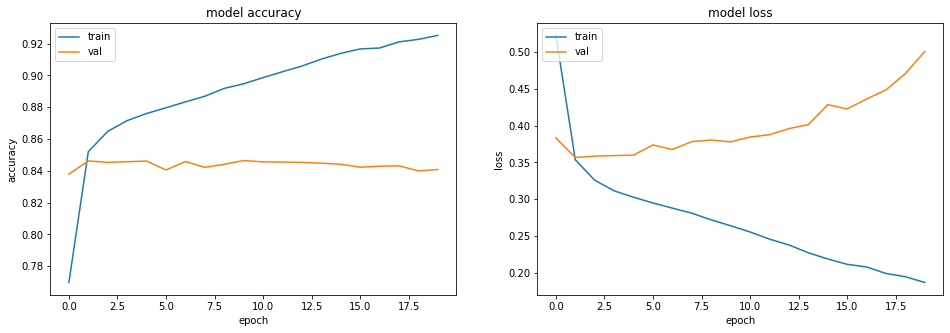

In [21]:
import keras
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

LSTM모델은 학습을 반복하면서 오히려 평가 데이터의 정확도는 내려가는 모습을 보여준다. 오버피팅이 되었다.

#### CNN Loss and Accuracy graph

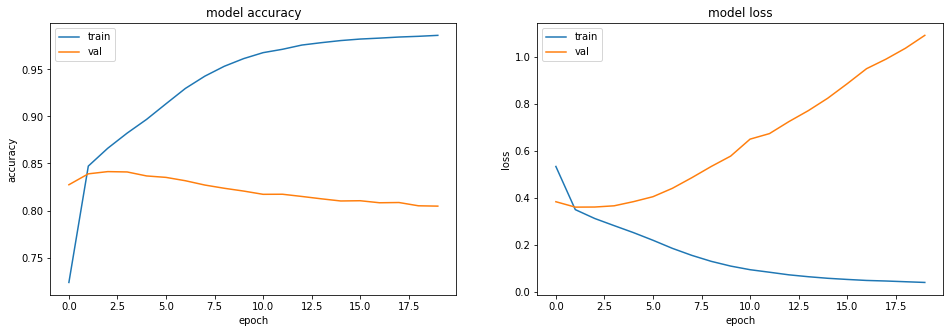

In [22]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

CNN모델 역시 반복 학습할수록 평가 데이터셋에서 안좋은 정확도를 보여준다.

#### GMP  Loss and Accuracy graph

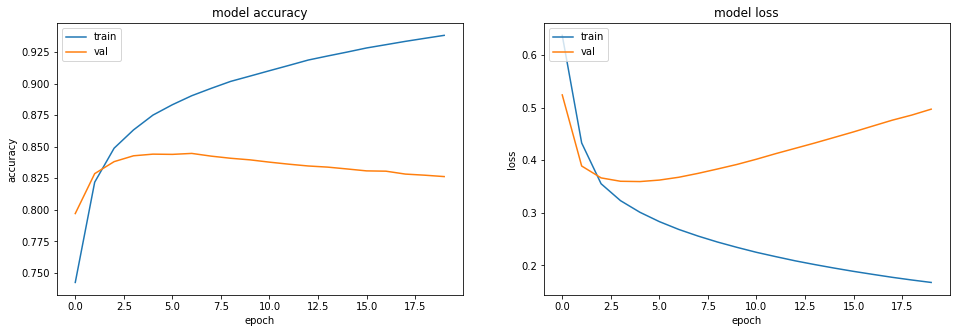

In [23]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(GMP_history.history['accuracy'])
plt.plot(GMP_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(GMP_history.history['loss'])
plt.plot(GMP_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

GMP 모델도 마찬가지다. 세 가지 모델에서 모두 반복 학습할 경우 평가 데이터의 정확도는 내려갔다.

## 7. 학습된 Embedding 레이어 분석

#### Embedding Layer (vocab_size, embedding_dim)

In [24]:
print(LSTM_model.layers[0].get_weights()[0].shape)    # shape: (vocab_size, embedding_dim)
print(CNN_model.layers[0].get_weights()[0].shape)
print(GMP_model.layers[0].get_weights()[0].shape)

(10000, 16)
(10000, 16)
(10000, 16)


In [25]:
## 사용했던 모델의 첫번째 레이어 : 임베딩 레이어 (단어개수×워드벡터사이즈 크기의 학습 파라미터)
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
LSTM_vectors = LSTM_model.layers[0].get_weights()[0]
CNN_vectors = CNN_model.layers[0].get_weights()[0]
GMP_vectors = GMP_model.layers[0].get_weights()[0]

# LSTM
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(LSTM_vectors[i, :])))))
f.close()

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
print('--LSTM--')
print(vector)
print(word_vectors.similar_by_word("가족"))
print('\n')

# CNN
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_CNN.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(CNN_vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
print('--CNN--')
print(vector)
print(word_vectors.similar_by_word("가족"))
print('\n')

# GMP
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_GMP.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(GMP_vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
print('--GMP--')
print(vector)
print(word_vectors.similar_by_word("가족"))

--LSTM--
[-0.12575583 -0.10465761  0.05824906  0.06071623 -0.12967622 -0.0324341
  0.08617882 -0.06948817 -0.13877699  0.11481613 -0.07253946 -0.14038505
 -0.04105004 -0.06962251  0.10914396  0.11051722]
[('터미네이터', 0.9531941413879395), ('뎁', 0.9514484405517578), ('사실', 0.9440614581108093), ('최강', 0.9379934668540955), ('울리', 0.9377959966659546), ('블랙', 0.9366007447242737), ('귀여움', 0.9334976673126221), ('이뻐', 0.9253608584403992), ('유리', 0.9234136939048767), ('문득', 0.9228491187095642)]


--CNN--
[ 0.00219108  0.06993479 -0.02525342 -0.1151337   0.0364261  -0.11849567
 -0.08704322 -0.01371964 -0.01326354 -0.08932166  0.14882416 -0.09248449
 -0.02489945 -0.07144974  0.07345233  0.10006426]
[('모리꼬네', 0.8377578258514404), ('느라', 0.8285610675811768), ('단연코', 0.8258386254310608), ('사', 0.8216800093650818), ('소위', 0.798486590385437), ('소림축구', 0.7504988312721252), ('감격', 0.7410632371902466), ('스릴감', 0.7345321774482727), ('~~~~~~', 0.7330998778343201), ('실태', 0.7315492630004883)]


--GMP--
[-0.037

가족과 유사한 단어를 찾아봤다.

LSTM에서 심장, CNN에서 해피, 결합, GMP에서 호호 정도가 그나마 관대하게 보면 유사한 단어라고 볼 수 있겠지만
모두 가족이라는 단어와 유사한 데이터를 보여준다고 하기 어려웠다.

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

그렇다면 기존의 학습된 모델을 활용한다면 얼마나 좋은 성능을 보여주는 지 확인해보자

### 작업요소
- 한국어 Word2Vec은 word2vec_ko.model을 활용

#### Word2Vec 임베딩 데이터를 활용해보자.

In [26]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = os.getenv('HOME') + '/data/word2vec_ko.model'

word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv["끝"]

In [27]:
word_vectors.wv.similar_by_word("가족")

[('친지', 0.7300689220428467),
 ('부모', 0.6990540027618408),
 ('부부', 0.6895633935928345),
 ('남편', 0.6893635392189026),
 ('애인', 0.683903157711029),
 ('연인', 0.6679908037185669),
 ('노인', 0.6658742427825928),
 ('주변인', 0.6581283807754517),
 ('자녀', 0.6540878415107727),
 ('친구', 0.6528307795524597)]

가족과 매우 유사한 단어들을 보여준다. 내가 만들어본 모델과 비교해보면 놀라운 성능이다.

#### word2vec_ko. model의 Embedding Layer 구조 확인하기

In [28]:
print("word_vectors.wv.vectors.shape :", word_vectors.wv.vectors.shape)    ## Word2Vec_ko 의 Shape 를 확인
print("word_vectors.wv.vectors.shape[1] :", word_vectors.wv.vectors.shape[1])

vocab_size = vocab_size    ## 어휘사전의 크기
word_vector_dim = word_vectors.wv.vectors.shape[1]    ## 워드 벡터의 차원 수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
print("embedding_matrix.shape :", embedding_matrix.shape)

vocab_size :  10000
word_vectors.wv.vectors.shape : (302960, 100)
word_vectors.wv.vectors.shape[1] : 100
embedding_matrix.shape : (10000, 100)


#### Embedding Layer 교체하기

In [31]:
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [35]:
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
New_LSTM_model = tf.keras.Sequential()
New_LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용 input_shape=(None,)))
New_LSTM_model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
New_LSTM_model.add(tf.keras.layers.Dense(8, activation='relu'))
New_LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
New_LSTM_model.summary()

SyntaxError: positional argument follows keyword argument (2412111520.py, line 7)

# 회고

## 학습에 사용했던 개념

- 단어를 케라스 모델을 통해서 백터로 임베딩 하는 것
- 감성 사전을 만들어보기
    - 결측치, 중복값 불용어들은 제거
    - 임베딩한 단어들의 최대 크기를 통일시키기
- LSTM 모델을 통해 시퀀스 데이터로서 텍스트 데이터를 학습시키기
- 1D-CNN 모델을 통해서 시퀀스 데이터처럼 학습시키기
- GMP 모델을 통해서 시퀀스 데이터처럼 학습시키기
- 기존 학습된 word2vec을 활용하기

작사가 인공지능 만들기 이후, NLP 2회차 과제였는데, 쉽지 않았다. 실습 자체는 LMS를 따라서 진행했다면 크게 어렵지 않았다. 같이 과제를 진행했던 동기들에게 많은 도움을 받아서 진행했다. 아직도 공부해야할 개념들이 많이 있는 거 같아서 걱정이 크다.

## 실습 시 아쉬운 점

- 더 많은 데이터 전처리 과정을 거치지 못해서 결과값이 아쉽다.


## 앞으로 공부해볼 것

- 더 나은 모델을 만들기 위해서 어떠한 것들이 있을까?
- 다양한 NLP 실습을 통해 배울 수 있길 바란다.